# Investigating the Slice-Wasserstein Distance
### Brendan Mallery



### Introduction

The Wasserstein (Earth Mover's, Optimal Transport) distance has recently found many applications in both pure and applied mathematics. We define it as follows:

Let $\mu,\nu$ be two probability measures on a metric space $(X,d)$. Let $\Pi(\mu,\nu)$ denote the set of couplings between $\mu$ and $\nu$, i.e. all probability measures $\zeta$ on $X\times X$ with marginals $\pi_1(\zeta)$ and $\pi_2(\zeta)$ given by $\mu$ and $\nu$ (where $\pi_i$ is projection onto the $i$'th factor. Then the Wasserstein distance (w.r.t. the ground metric $d$) between $\mu$ and $\nu$ is defined $$W(\mu,\nu)=\inf_{\zeta\in \Pi(\mu,\nu)} \int_{X\times X} d(x,y)d\zeta(x,y).$$ The Wasserstein distance has many desirable properties, and has seen use as an intuitive and interpretable metric on probability distributions. 

For the rest of our discussion we restrict our attention to $X=\mathbb{R}^d$ with the standard metric. For low dimensions, computing the Wasserstein distance can be done fairly quickly. In particular, when $d=1$, it is not difficult to show that there is a closed form solution for $W(\mu,\nu)$. As $n$ increases however, these computations become more and more intractible. In light of this, by now there are several methods to approximate the Wasserstein distance in these more difficult cases. For instance, a regularized problem has recently been introduced where $W(\mu,\nu)$ is replaced with $$\inf_{\zeta\in\Pi(\mu,\nu)} \int_{X\times X} d(x,y)d\zeta(x,y)+\epsilon H(\pi|\mu\otimes \nu)$$ where $\epsilon>0$ and $H(P|Q)$ is the relative entropy btween $P$ and $Q$. This entropy regularized problem yields a solution that is less "singular" than those in the original problem. Furthermore this solution is unique and converges to the true solution when $\epsilon\rightarrow 0$. 

In this report, we consider a different approach to approximating $W(\mu,\nu)$: Recall that for measures on $\mathbb{R}$, $W(\mu,\nu)$ may be written $\int_0^1 d(F^{-1}_\mu(z),F^{-1}_\nu(z))dz$, where $F_\mu$ ($F_\nu$) denotes the cumulative distribution function of $\mu$ (resp. $\nu$). This motivates the definition of the sliced Wasserstein metric: Let $\mu,\nu$ be probability distributions in $\mathbb{R}^d$, and let $\theta\in S^{d-1}$, where $S^{d-1}$ is the unit sphere in $\mathbb{R}^d$. Then $SW(\mu,\nu)=\int_{S^{d-1}}W(\pi_\theta(\mu),\pi_\theta(\nu))d\theta$ where $\pi_\theta$ denotes projection onto the unique 1-dimensional subspace defined by $\theta$. It has been shown that this indeed defines a distance, and furthermore that $$SW(\mu,\nu)\leq W(\mu,\nu)\leq \alpha SW^\beta(\mu,\nu)$$ for $\alpha,\beta\in \mathbb{R}$. This shows that $SW$ provides a control for $W$.

The goal of this project is to investigate how $SW$ works in practice. For instance, it is clearly impractical to integrate $W(\pi_\theta(\mu),\pi_\theta(\nu))$ over all directions in $S^{d-1}$, and hence this must be done by uniformly sampling directions. How quickly does $SW$ converge to a value under this sampling? Does higher sampling result in closer approximations to $W$? Do these answers change as $d$ increases? 

To answer these questions, we will construct pairs of probability distributions $\mu,\nu$ for which we know the true value of $W(\mu,\nu)$. We will then use these pairs to explore the above questions. We will also attempt to develop heuristics to improve the computation of $SW$, for instance, by choosing orthogonal directions in $S^{d-1}$ as opposed to random ones. Finally, we will attempt to compute a modified sliced Wasserstein distance, where $\mu$ and $\nu$ are projected onto subspaces of arbitrary dimension.

## Constructing Distributions

To begin with we must construct our distributions of interest. We choose multivariate Gaussians for two reasons: First, we may define them in arbitrary dimension, which will be useful for our experiments. Second, it is possible to exactly compute the Wasserstein distance between two d-dimensional Gaussians.

A d-dimensional Gaussian is defined by specifying its mean (a $d$-dimensional vector) and a $d\times d$ covariance matrix. Every covariance matrix is a symmetric, positive semidefinite matrix and vice versa, so we do this by choosing random mean vectors and positive semidefinite matrices. For our experiments, we will use d-dimensional Gaussians for $d=3,5,10$.

In [61]:
import numpy as np
from scipy import stats,linalg
import ot
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

def randcov(size):
    A = np.random.rand(size, size)
    B = np.dot(A, A.transpose())
    return B

def gaussian(mean,matrix):
    if len(mean)!=len(matrix):
        return "Wrong size mate"
    A=stats.multivariate_normal(mean,matrix)
    return A

dims=[3,5,10]
Adists=[]
Bdists=[]
Aparams=[]
Bparams=[]
for i in dims:
    Atemp=randcov(i)
    Btemp=randcov(i)
    Amean=np.random.rand(i)
    Bmean=4*np.random.rand(i)
    Aparams.append([Amean,Atemp])
    Bparams.append([Bmean,Btemp])
for i in np.arange(len(dims)):
    Adists.append(gaussian(Aparams[i][0],Aparams[i][1]))
    Bdists.append(gaussian(Bparams[i][0],Bparams[i][1]))

As is derived in: https://djalil.chafai.net/blog/2010/04/30/wasserstein-distance-between-two-gaussians/, the Wasserstein distance between two Gaussians $\mu=\mathcal{N}(m_1,\Sigma_1),\nu=\mathcal{N}(m_2,\Sigma_2)$ is given by $$W(\mu,\nu)^2=||m_1-m_2||^2+Tr(\Sigma_1+\Sigma_2-2(\Sigma_1^{1/2}\Sigma_2\Sigma_1^{1/2})^{1/2}).$$ Here, for a positive semidefinite matrix $A$, $A^{1/2}$ denotes a matrix $B$ such that $BB^T=A$. Note that since $A$ is a covariance matrix, and hence positive semidefinite, this $B$ is unique. We compute these values for each of our test distributions.

In [21]:
def gausswassexact(Xmean,Xcov,Ymean,Ycov):
    #annoying that you can't extract these stats from multivariate_normal..
    #could obtain by sampling, which i'll do in another function
    Xmean=np.asarray(Xmean)
    Ymean=np.asarray(Ymean)
    Term1=np.linalg.norm(Xmean-Ymean)**2
    SqrtX=linalg.sqrtm(Xcov)
    Term2=np.matrix.trace(Xcov+Ycov-2*linalg.sqrtm((np.matmul(SqrtX,np.matmul(Ycov,SqrtX)))))
    Wass=np.sqrt(Term1+Term2)
    return Wass

ExactWass=[]
for i in np.arange(len(dims)):
    ExactWass.append(gausswassexact(Aparams[i][0],Aparams[i][1],Bparams[i][0],Bparams[i][1]))
    
ExactWass


[0.8006669660354893, 4.913013543851106, 5.948856969205848]

## Computing the slice Wasserstein distance

We now look to computing the slice Wasserstein distance for our distributions. We do this for each $d$ by computing random directions $\theta$ in the sphere $S^{d-1}$, which are unit vectors in $\mathbb{R}^d$. Then we draw samples $x\sim \mu,y\sim \nu$ from both distributions and project these samples onto these vectors: $$\pi_\theta(x)=\frac{\langle x,\theta\rangle}{\langle \theta,\theta \rangle}\theta=\langle x,\theta \rangle\theta$$ $$\pi_\theta(y)=\frac{\langle y,\theta\rangle}{\langle \theta,\theta \rangle}\theta=\langle y,\theta \rangle\theta$$

The new distributions we obtain this way are sampled from $(\pi_\theta)_*(\mu),(\pi_\theta)_*(\nu)$, the pushforward distributions of $\mu$ and $\nu$ under the transformation $\pi_\theta$. We then compute the 1-dim Wasserstein distance between these distributions using the package "Python Optimal Transport." We select our random directions in $S^{d-1}$ by drawing from a $d$-dimensional standard Gaussian and normalizing the results.


In [54]:
def randomdirections(dimension,samples):
        D=[]
        for i in np.arange(samples):
            u=np.random.normal(0,1,dimension)
            direction=u/np.linalg.norm(u)
            D.append(direction)
        return D
    
def projectsamples(direction,samplesX,samplesY):
        if len(samplesX)!=len(samplesY):
            print("Size mismatch")
            #could also pad
        else:
            pX=[]
            pY=[]
            for i in np.arange(len(samplesX)):
                #projections
                projx=(np.dot(direction,samplesX[i]))*direction
                projy=(np.dot(direction,samplesY[i]))*direction
                pX.append(projx)
                pY.append(projy)
        return pX,pY

    
def slicedwasserstein(Xdata,Ydata,directions):
        Xsamp=Xdata
        Ysamp=Ydata
        dim=len(Xsamp[0])
        D=directions
        if len(D[0])!=dim:
            print("dim mismatch")
        else:
            slicedist=0
            for i in np.arange(len(directions)):
                Xvec,Yvec=projectsamples(D[i],Xsamp,Ysamp)
                M=euclidean_distances(Xvec,Yvec)
                dist=ot.emd2([],[],M)
                slicedist=slicedist+(1/len(directions))*dist
        return slicedist
        


We now compute the sliced Wasserstein distance between our distributions. We keep the number of samples fixed ($n=100$) and vary the number of slices. To account for possible variation due to sampling, we run multiple trials (#trials$=10$) for each distribution and take the average values across these trials. For each trial, we first sample a set of directions $D$ ($|D|=200$). Then we construct filtration of D by increasing sets $$F_0\subset F_1\subset...\subset F_m=D,$$ and at each step $i$ compute the slice Wasserstein distance projected onto the set of directions in $F_i$.

In [72]:
slices=[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

def slicetrials(X,Y,slicelist,trials):
    A=[]
    dim=len(X[0])
    for i in np.arange(trials):
        maxslice=max(slicelist)
        directions=randomdirections(dim,maxslice)
        Atemp=[]
        for j in slicelist:
            directstemp=directions[0:j]
            Atemp.append(slicedwasserstein(X,Y,directstemp))
        A.append(Atemp)
    return A

def sliceavg(A):
    B=[]
    for i in np.arange(len(A[0])):
        z=0
        for j in A:
            z=z+(1/len(A))*j[i]
        B.append(z)
    return B

Xsamps3=Adists[0].rvs(size=100)
Ysamps3=Bdists[0].rvs(size=100)
Xsamps5=Adists[1].rvs(size=100)
Ysamps5=Bdists[1].rvs(size=100)
Xsamps10=Adists[2].rvs(size=100)
Ysamps10=Bdists[2].rvs(size=100)

Q3=slicetrials(Xsamps3,Ysamps3,slices,10)
Q5=slicetrials(Xsamps5,Ysamps5,slices,10)
Q10=slicetrials(Xsamps10,Ysamps10,slices,10)

## Results

Below we plot the results of our computations. The blue lines denote the results from the various trials. The red line indicates the average over these trials. For all three dimensions, we see that the values from the various trials appear to converge past $100$ slices, after some initial variation. We also compute the expectation and the variance of the trials at the maximum number of slices. Interestingly, we see that the variance seems to decrease as dimension increases, indicating that the slice Wasserstein distance converges more quickly when the ambient dimension is higher. This is likely because of the concentration of measure phenomenon, which states that samples from $S^{d-1}$ become highly concentrated around the mean as $d$ increases. 

We also note that the slice Wasserstein distance is noticably less than the actual Wasserstein distance in these three cases, and this gap seems to grow as the dimension increases (though of course, this could be an artefact of the specific distributions we chose). It seems intuitive that projecting onto one-dimensional subspaces becomes less indicative as the ambient dimension increases. As explained in the introduction, $W(\mu,\nu)\leq \alpha SW^\beta(\mu,\nu)$, and as shown in the thesis: https://www.normalesup.org/~bonnotte/doc/phd-bonnotte.pdf the $\beta$ in the above inequality is dependent on the ambient dimension.

In [275]:
def plot_trials(Q,slices,color1,color2):
    for i in np.arange(len(Q)):
        plt.plot(slices,Q[i],color=color1,linewidth=2,alpha=0.4)
        Qavg=sliceavg(Q)
        plt.plot(slices,Qavg,color=color2,linewidth=2)
        plt.figtext(0.5, 0.01, "Slices", wrap=True, horizontalalignment='center', fontsize=12)


3-dim Gaussians
Wasserstein distance: 3.833038634511036
Mean slice distance at max slices: 1.9226007954422784
Variance at max slices: 0.05981692850004818


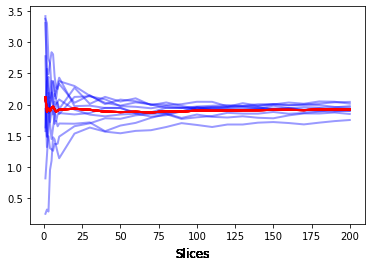

In [276]:
plot_trials(Q3,slices,"blue","red")
mean=sliceavg(Q3)[-1]
spread=[]
for i in np.arange(len(Q3)):
    spread.append(Q3[i][len(Q3)])
print("3-dim Gaussians")
print("Wasserstein distance:",ot.emd2([],[],euclidean_distances(Xsamps3,Ysamps3)))
print("Mean slice distance at max slices:", mean)
print("Variance at max slices:", np.var(spread))


5-dim Gaussians
Wasserstein distance: 4.4895443757002935
Mean slice distance at max slices: 1.6892831157651895
Variance at max slices: 0.02567288715643583


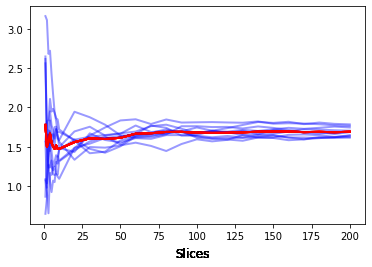

In [277]:
plot_trials(Q5,slices,"blue","red")
spread=[]
mean=sliceavg(Q5)[-1]
spread=[]
for i in np.arange(len(Q5)):
    spread.append(Q5[i][len(Q5)])
print("5-dim Gaussians")
print("Wasserstein distance:",ot.emd2([],[],euclidean_distances(Xsamps5,Ysamps5)))
print("Mean slice distance at max slices:", mean)
print("Variance at max slices:", np.var(spread))


10-dim Gaussians
Wasserstein distance: 6.219257630413816
Mean slice distance at max slices: 1.5072553963701751
Variance at max slices: 0.01320407768611386


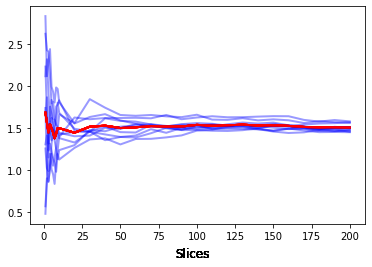

In [278]:
plot_trials(Q10,slices,"blue","red")
mean=sliceavg(Q10)[-1]
spread=[]
for i in np.arange(len(Q10)):
    spread.append(Q10[i][len(Q10)])
print("10-dim Gaussians")
print("Wasserstein distance:",ot.emd2([],[],euclidean_distances(Xsamps10,Ysamps10)))
print("Mean slice distance at max slices:", mean)
print("Variance at max slices:", np.var(spread))


## Further experimentation

### Orthogonal sampling

We now consider extensions to the slice Wasserstein distance. For our first extension, we replace random sampling in $S^{d-1}$ by sampling in orthogonal directions: Explicitly, we sample in batches of size $d$, and perform Gram-Schmidt orthonormalization on the vectors obtained this way. The idea here is that this might reduce the amount of information about the distribution that is "shared" between different samples, hopefully leading to faster convergence.  We refer to this method as Ortho-Slice Wasserstein

In [203]:

slices2=[1,2,3,4,5,10,20,30,40,50,60,70,80,90,100,110,120,130]

def orthogonaldirections(dimension,samples):
        X=randomdirections(dimension,samples)
        Y=[]
        for i in np.arange(len(X)):
                v=X[i]
                for w in Y:
                    projv=np.dot(v,w)/np.linalg.norm(w)*w
                    v=v-projv
                Y.append(v/np.linalg.norm(v))
        return Y
    
def ortholist(dimension,totalslices):
    counter=0
    D=[]
    Dtemp=[]
    while counter<totalslices:
        #for the number of batches
        Dtemp=orthogonaldirections(dimension,dimension)
        #sample dim=n orthogonal vectors
        for v in Dtemp:
            D.append(v)
            counter=counter+1
    return D

    
def orthoslice(Xdata,Ydata,orthodirections):
        Xsamp=Xdata
        Ysamp=Ydata
        dim=len(Xsamp[0])
        slicedist=0
        D=orthodirections
        for i in np.arange(len(D)):
            Xvec,Yvec=projectsamples(D[i],Xsamp,Ysamp)
            M=euclidean_distances(Xvec,Yvec)
            dist=ot.emd2([],[],M)
            slicedist=slicedist+(1/len(D))*dist
        return slicedist

def orthoslicetrials(X,Y,slicelist,trials):
    A=[]
    dim=len(X[0])
    maxslice=max(slicelist)
    for i in np.arange(trials):
        directions=ortholist(dim,maxslice)
        Atemp=[]
        for j in slicelist:
            directstemp=directions[0:j]
            Atemp.append(slicedwasserstein(X,Y,directstemp))
        A.append(Atemp)
    return A



O3=orthoslicetrials(Xsamps3,Ysamps3,slices2,10)
O5=orthoslicetrials(Xsamps5,Ysamps5,slices2,10)
O10=orthoslicetrials(Xsamps10,Ysamps10,slices2,10)


[[1.5207905834660325,
  1.7135714738026602,
  2.087126319761831,
  2.1225245497854406,
  2.0493434989525188,
  2.12492066421732,
  1.991952389906995,
  1.934128323446519,
  1.9360822573564422,
  1.9053961009337175,
  1.9462106027224484,
  1.9447612336748434,
  1.8925648446880836,
  1.864759885793172,
  1.8720852387632174,
  1.8699991757615984,
  1.8795032453078016,
  1.8760747664964637],
 [3.584385928816716,
  2.1784789994555966,
  1.6975776212040654,
  1.4738688764081005,
  1.8411910659043633,
  1.764418072817187,
  1.8756162837122958,
  1.8169302152892615,
  1.8807142862544166,
  1.8624094741764379,
  1.8734347795769473,
  1.9153223738957623,
  1.886980167859831,
  1.8448346964588136,
  1.8761738265143393,
  1.875340078615317,
  1.8697236383591849,
  1.8725867083591412],
 [1.793312308028116,
  2.0447440632601377,
  2.1442932770530234,
  1.8254183464341394,
  1.6909377382300244,
  2.130397917978313,
  1.8436500875389077,
  1.8890511904803382,
  1.8890120406223587,
  1.8604624054603738

3-dim Gaussians with orthogonal slices
Wasserstein distance: 3.833038634511036
Mean orthoslice distance at max slices: 1.9016953968589183
Variance at max orthoslices: 0.003631761034346334
Blue: Ortho-Slice-Wasserstein
Orange: Slice-Wasserstein


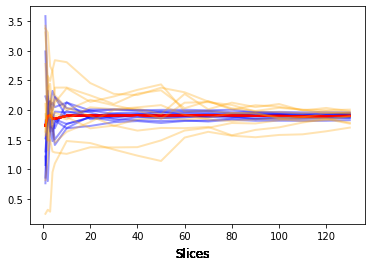

In [308]:
def truncate(listoflists, length):
    Z=[]
    for i in listoflists:
        if len(i)>length:
            Ztemp=i[0:length]
            Z.append(Ztemp)
    return Z

plot_trials(O3,slices2,"blue","red")
mean=sliceavg(O3)[-1]
spread=[]
Q3trunc=truncate(Q3,len(slices2))
for i in np.arange(len(Q3trunc)):
    plt.plot(slices2,Q3trunc[i],color="orange",linewidth=2,alpha=0.3)

for i in np.arange(len(O3)):
    spread.append(O3[i][len(O3)])



print("3-dim Gaussians with orthogonal slices")
print("Wasserstein distance:",ot.emd2([],[],euclidean_distances(Xsamps3,Ysamps3)))
print("Mean orthoslice distance at max slices:", mean)
print("Variance at max orthoslices:", np.var(spread))
print("Blue: Ortho-Slice-Wasserstein")
print("Orange: Slice-Wasserstein")

5-dim Gaussians with orthogonal slices
Wasserstein distance: 3.833038634511036
Mean orthoslice distance at max slices: 1.6558700456872042
Variance at max orthoslices: 0.000693653365016402
Blue: Ortho-Slice-Wasserstein
Orange: Slice-Wasserstein


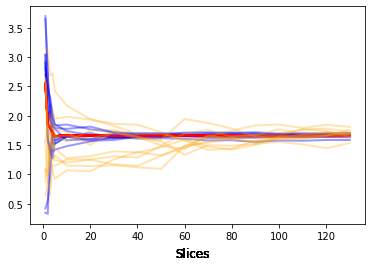

In [298]:
plot_trials(O5,slices2,"blue","red")
mean=sliceavg(O5)[-1]
spread=[]
for i in np.arange(len(O5)):
    spread.append(O5[i][len(O5)])
Q5trunc=truncate(Q5,len(slices2))
for i in np.arange(len(Q5trunc)):
    plt.plot(slices2,Q5trunc[i],color="orange",linewidth=2,alpha=0.3)

print("5-dim Gaussians with orthogonal slices")
print("Wasserstein distance:",ot.emd2([],[],euclidean_distances(Xsamps3,Ysamps3)))
print("Mean orthoslice distance at max slices:", mean)
print("Variance at max orthoslices:", np.var(spread))

10-dim Gaussians with orthogonal slices
Wasserstein distance: 6.219257630413816
Mean orthoslice distance at max slices: 1.458023577167668
Variance at max orthoslices: 0.0013809379915747488
Blue: Ortho-Slice-Wasserstein
Orange: Slice-Wasserstein


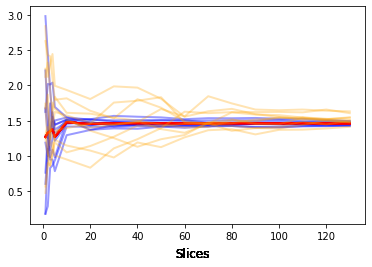

In [299]:
plot_trials(O10,slices2,"blue","red")
mean=sliceavg(O10)[-1]
spread=[]
for i in np.arange(len(O10)):
    spread.append(O10[i][len(O10)])
Q5trunc=truncate(Q10,len(slices2))
for i in np.arange(len(Q10trunc)):
    plt.plot(slices2,Q10trunc[i],color="orange",linewidth=2,alpha=0.3)

print("10-dim Gaussians with orthogonal slices")
print("Wasserstein distance:",ot.emd2([],[],euclidean_distances(Xsamps10,Ysamps10)))
print("Mean orthoslice distance at max slices:", mean)
print("Variance at max orthoslices:", np.var(spread))
print("Blue: Ortho-Slice-Wasserstein")
print("Orange: Slice-Wasserstein")

The above plots appear to show that the Ortho-Slice Wasserstein distance begin converging in significantly fewer iterations than the Slice Wasserstein distance. To more explicitly demonstrate this, below we plot the variance of the distance values over different trials versus the number of slices taken. We see that this is indeed the case, and that the variance in the Ortho-Slice case rapidly drops after only a few slices. This bears some resemblance to how conjugate gradient descent converges more quickly than gradient descent.

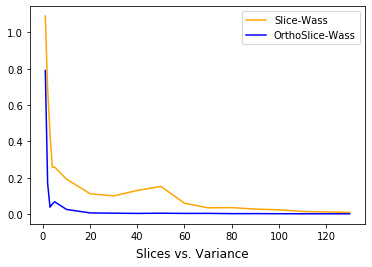

In [309]:
def slicevar(A):
    C=[]
    for i in np.arange(len(A[0])):
        vartemp=[]
        for j in A:
            vartemp.append(j[i])
        V=np.var(vartemp)
        C.append(V)
    return C
Q3trunc=truncate(Q3,len(slices2))
Q5trunc=truncate(Q5,len(slices2))
Q10trunc=truncate(Q10,len(slices2))
plt.plot(slices2,slicevar(Q3trunc),color="orange",label="Slice-Wass")
plt.plot(slices2,slicevar(O3),color="blue",label="OrthoSlice-Wass")
plt.figtext(0.5, 0.01, "Slices vs. Variance", wrap=True, horizontalalignment='center', fontsize=12)
plt.legend()

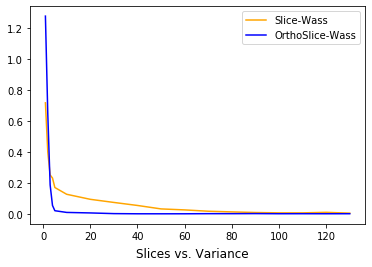

In [310]:
plt.plot(slices2,slicevar(Q5trunc),color="orange",label="Slice-Wass")
plt.plot(slices2,slicevar(O5),color="blue",label="OrthoSlice-Wass")
plt.figtext(0.5, 0.01, "Slices vs. Variance", wrap=True, horizontalalignment='center', fontsize=12)
plt.legend()

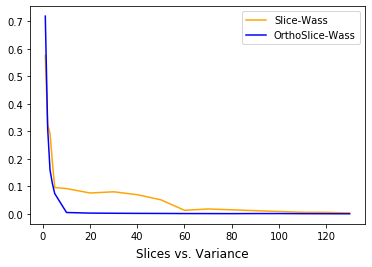

In [311]:
plt.plot(slices2,slicevar(Q10trunc),color="orange",label="Slice-Wass")
plt.plot(slices2,slicevar(O10),color="blue",label="OrthoSlice-Wass")
plt.figtext(0.5, 0.01, "Slices vs. Variance", wrap=True, horizontalalignment='center', fontsize=12)
plt.legend()

### 2-dimensional slices

For our second extension, we define an analog of the slice Wasserstein distance where instead of averaging over projections of the original distributions to randomly sampled 1-dimensional subspaces, we average over randomly sampled 2-dimensional subspaces. We conjectured that this would result in a closer approximation to the actual Wasserstein distance between two distributions than the 1-dimensional case, and indeed that this relationship would continue to hold when higher dimensional projections were used (observe that when projections are "top dimensional" one recovers the true Wasserstein distance). 

The 2-dimensional slice-Wasserstein distance is computed identically to the regular slice-Wasserstein distance, except for the projection step, where the 1-dimensional projection formula is replaced by the following: Let $u,v\in S^{d-1}$, and let $M$ denote the $d\times 2$ matrix with columns given by $u$ and $v$. Then the two dimensional projection matrix onto the subspace spanned by $u$ and $v$ is given by $P=M(M^T M)^{-1}M^T$. Once again, we sample from the $P_*(\mu),P_*(\nu)$ the pushforward distributions of $\mu$ and $\nu$ under this map, and compute the 2-dimensional Wasserstein distance using the package "Python Optimal Transport."

In [339]:
def random2dimproj(dimension,slices):
    Proj=[]
    for i in np.arange(slices):
        u,v=randomdirections(dimension,2)
        M=np.asarray([u,v])
        N=np.linalg.inv(np.matmul(M,np.transpose(M)))
        P=np.matmul(np.matmul(np.transpose(M),N),M)
        Proj.append(P)
    return Proj

def slice_2dim(X,Y,projections):
        Xsamp=X
        Ysamp=Y
        dim=len(Xsamp[0])
        slicedist=0
        for i in np.arange(len(projections)):
            for j in np.arange(len(Xsamp)):
                pX=projections[i]*np.reshape(Xsamp[j],(dim,1))
                pY=projections[i]*np.reshape(Ysamp[j],(dim,1))
                slicedist=slicedist+(1/len(projections))*ot.emd2([],[],euclidean_distances(pX,pY))
        return slicedist

def twodimslicetrials(X,Y,slicelist,trials):
    A=[]
    dim=len(X[0])
    maxslice=max(slicelist)
    for i in np.arange(trials):
        directions=random2dimproj(dim,maxslice)
        Atemp=[]
        for j in slicelist:
            directstemp=directions[0:j]
            Atemp.append(slice_2dim(X,Y,directstemp))
        A.append(Atemp)
    return A

In [338]:
dims=[20,40]
Abigdists=[]
Bbigdists=[]
Abigparams=[]
Bbigparams=[]
for i in dims:
    Abigtemp=randcov(i)
    Bbigtemp=randcov(i)
    Abigmean=np.random.rand(i)
    Bbigmean=4*np.random.rand(i)
    Abigparams.append([Abigmean,Abigtemp])
    Bbigparams.append([Bbigmean,Bbigtemp])
for i in np.arange(len(dims)):
    Abigdists.append(gaussian(Abigparams[i][0],Abigparams[i][1]))
    Bbigdists.append(gaussian(Bbigparams[i][0],Bbigparams[i][1]))

Xsamps20=Abigdists[0].rvs(size=100)
Xsamps40=Abigdists[1].rvs(size=100)
Ysamps20=Bbigdists[0].rvs(size=100)
Ysamps40=Bbigdists[1].rvs(size=100)
P3=random2dimproj(3,100)
P5=random2dimproj(5,100)
P10=random2dimproj(10,100)
P20=random2dimproj(20,100)
P40=random2dimproj(40,100)
print("100 slices of 2dim-slice vs. Wasserstein, 3-dim Gaussian:")
print(slice_2dim(Xsamps3,Ysamps3,P3),"----",ot.emd2([],[],euclidean_distances(Xsamps3,Ysamps3)))
print("100 slices of 2dim-slice vs. Wasserstein, 5-dim Gaussian:")
print(slice_2dim(Xsamps5,Ysamps5,P5),"----",ot.emd2([],[],euclidean_distances(Xsamps5,Ysamps5)))
print("100 slices of 2dim-slice vs. Wasserstein, 10-dim Gaussian:")
print(slice_2dim(Xsamps10,Ysamps10,P10),"----",ot.emd2([],[],euclidean_distances(Xsamps10,Ysamps10)))
print("100 slices of 2dim-slice vs. Wasserstein, 20-dim Gaussian:")
print(slice_2dim(Xsamps20,Ysamps20,P20),"----",ot.emd2([],[],euclidean_distances(Xsamps20,Ysamps20)))
print("100 slices of 2dim-slice vs. Wasserstein, 40-dim Gaussian:")
print(slice_2dim(Xsamps40,Ysamps40,P40),"----",ot.emd2([],[],euclidean_distances(Xsamps40,Ysamps40)))

100 slices of 2dim-slice vs. Wasserstein, 3-dim Gaussian:
158.3554559805614 ---- 3.833038634511036
100 slices of 2dim-slice vs. Wasserstein, 5-dim Gaussian:
102.99466882037538 ---- 4.4895443757002935
100 slices of 2dim-slice vs. Wasserstein, 10-dim Gaussian:
76.73386175905407 ---- 6.219257630413816
100 slices of 2dim-slice vs. Wasserstein, 20-dim Gaussian:
60.51968980019412 ---- 10.688254480285718
100 slices of 2dim-slice vs. Wasserstein, 40-dim Gaussian:
46.771925407366226 ---- 16.871041448040824


The cell above shows comparisons between the 2-dim slice-Wasserstein distance (with 100 slices) and the true Wasserstein distance. It is immediately apparent that the the 2-dim slice-Wasserstein distance is not bounded above by the Wasserstein distance. It would be interesting to determine, either analytically or empirically what scale factors are needed to achieve similar bounds as in the 1-dim case, but this is beyond the scope of this report. One final comment is that as the dimension increases, the 2-dim-slice Wasserstein distance decreases, while the true Wasserstein distance increases. It is not clear whether this always holds or if it is an artefact of the chosen distributions or the method with which we defined them, and this may warrant further exploration.